### Name: 
**Sajith Gowthaman**
### Project Name:
Final Capstone - Predicting Covid-19 using Regression model and Convolutional Neural Networks.

### Description:
Covid-19: A novel coronavirus is a new strain of coronavirus that has not been previously identified in humans.
Coronaviruses (CoV) are a large family of viruses transmitting between animals and people that cause illness ranging from the common cold to more severe diseases such as Middle East respiratory syndrome (MERS-CoV) and severe acute respiratory syndrome (SARS-CoV).

As the virus is wild spread, it is the duty of data scientists and enthusiasts to provide the health care industry with useful insights.


![unnamed](https://user-images.githubusercontent.com/55968160/80875853-be49fd80-8c6f-11ea-8ded-75588694181d.png)


The project is split into two parts:
1) Predicting the positive cases using Regression Model
2) Predicting the chest x-ray image using Convolutional Neural Network

The [data]('https://covidtracking.com/') for predicting the positive cases is taken from the "The Covid-19 Tracking Project". The data is uploaded on a daily basis. This part of the project will include useful insights, grouped statewise to find solutions through record of improvement. 

The data for predicting the chest x-rays are taking from an open base research dataset on a [github repository]('https://github.com/ieee8023/covid-chestxray-dataset') where I was able to access 340+ (Augmented to about 3k+ images) Covid-19 chest xray images. I took a bunch of normal x-rays found on Kaggle to do this analysis.

### How is this project different and who will it help?
A lot of people have been using their time off to visualize the covid-19 which is really useful. 
This project will combine the unique idea of both predicting the positive cases and predicting the presence of the virus through just inserting the chest x-ray. This will ease the work load on health care workers to assume the present of covid-19 without waiting 3 days for the test results. The patient could be treated as a victim of covid-19 if the deep learning model predicts positive, atleast till the clinical results come out.

In [1]:
#pandas, numpy, matplotlib, seaborn, scipy, sklearn libraries
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
import plotly.figure_factory as ff
import pandas as pd
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
#Image imports
from PIL import Image
from pathlib import Path
from skimage.io import imread
import cv2
from sklearn.metrics import confusion_matrix
#Keras

import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import missingno as msno

os.chdir("..")
warnings.filterwarnings('ignore')
matplotlib.style.use("fivethirtyeight")

Using TensorFlow backend.
/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a 

In [2]:
df = pd.read_csv("https://covidtracking.com/api/states/daily.csv")

In [3]:
df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
0  20200512    AK     383.0   29578.0      NaN                   10.0   
1  20200512    AL   10310.0  122908.0      NaN                    NaN   
2  20200512    AR    4164.0   66280.0      NaN                   59.0   
3  20200512    AS       0.0     105.0      NaN                    NaN   
4  20200512    AZ   11736.0  111106.0      NaN                  765.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     NaN             NaN              NaN   
1                  1287.0             NaN            468.0   
2                   485.0             NaN              NaN   
3                     NaN             NaN              NaN   
4                  1564.0           318.0              NaN   

   onVentilatorCurrently  ...  hospitalized   total totalTestResults  posNeg  \
0                    NaN  ...           NaN   29961            29961   29961   
1                    NaN  ...        1287.0  133218           133218  133218   
2                   12.0  ...         485.0   70444            70444   70444   
3                    NaN  ...           NaN     105              105     105   
4                  204.0  ...        1564.0  122842           122842  122842   

  fips deathIncrease  hospitalizedIncrease  negativeIncrease  \
0    2           0.0                   0.0            1279.0   
1    1          28.0                  31.0            3473.0   
2    5           1.0                   5.0            1284.0   
3   60           0.0                   0.0               0.0   
4    4          20.0                  27.0            6022.0   

   positiveIncrease  totalTestResultsIncrease  
0               2.0                    1281.0  
1             301.0                    3774.0  
2             130.0                    1414.0  
3               0.0                       0.0  
4             356.0                    6378.0  

[5 rows x 27 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 27 columns):
date                        3825 non-null int64
state                       3825 non-null object
positive                    3810 non-null float64
negative                    3637 non-null float64
pending                     729 non-null float64
hospitalizedCurrently       1563 non-null float64
hospitalizedCumulative      1532 non-null float64
inIcuCurrently              804 non-null float64
inIcuCumulative             323 non-null float64
onVentilatorCurrently       649 non-null float64
onVentilatorCumulative      106 non-null float64
recovered                   1407 non-null float64
dataQualityGrade            2720 non-null object
lastUpdateEt                3452 non-null object
hash                        3825 non-null object
dateChecked                 3825 non-null object
death                       3099 non-null float64
hospitalized                1532 non-null float64
total

Visualization

In [5]:
top_10 = df.sort_values('total',ascending = False).drop_duplicates(['state'])
top_10.state.head(10)

37    NY
5     CA
10    FL
47    TX
16    IL
34    NJ
21    MA
24    MI
41    PA
46    TN
Name: state, dtype: object

For visualization, we will use the top 10 states with the highest number of cases. 
* The states with the highest number of cases are NY, CA, FL, TX, MA, NJ, IL, PA, MI, WA

In [6]:
vis_df = df.loc[df['state'].isin(['NY','CA', 'FL', 'TX', 'MA', 'NJ', 'IL', 'PA', 'MI', 'WA'])]
## Reset Index
vis_df = vis_df.reset_index(drop=True)
vis_df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
0  20200512    CA   69382.0  963988.0      NaN                 4544.0   
1  20200512    FL   41923.0  537681.0   1064.0                    NaN   
2  20200512    IL   83021.0  388670.0      NaN                 4626.0   
3  20200512    MA   79332.0  322164.0      NaN                 3127.0   
4  20200512    MI   48021.0  259869.0      NaN                 1384.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     NaN          1349.0              NaN   
1                  7654.0             NaN              NaN   
2                     NaN          1215.0              NaN   
3                  7842.0           818.0              NaN   
4                     NaN           693.0              NaN   

   onVentilatorCurrently  ...  hospitalized    total totalTestResults  \
0                    NaN  ...           NaN  1033370          1033370   
1                    NaN  ...        7654.0   580668           579604   
2                  730.0  ...           NaN   471691           471691   
3                    NaN  ...        7842.0   401496           401496   
4                  525.0  ...           NaN   307890           307890   

    posNeg fips deathIncrease  hospitalizedIncrease  negativeIncrease  \
0  1033370    6          77.0                   0.0           40030.0   
1   579604   12          44.0                 196.0           17606.0   
2   471691   17         142.0                   0.0           25252.0   
3   401496   25          33.0                 110.0            5898.0   
4   307890   26          90.0                   0.0            8473.0   

   positiveIncrease  totalTestResultsIncrease  
0            1443.0                   41473.0  
1             941.0                   18547.0  
2            4014.0                   29266.0  
3             870.0                    6768.0  
4             469.0                    8942.0  

[5 rows x 27 columns]

In [7]:
vis_df1 = vis_df.copy()
vis_df1.date = pd.to_datetime(vis_df['date'], format='%Y%m%d')
vis_df1.date = vis_df1.date.max()
count_df = vis_df1.groupby(by=['date','state'])['positive'].max().reset_index()
count_df.sort_values('positive', ascending=False, inplace=True)
count_df = pd.DataFrame(count_df)
count_df

date state  positive
6 2020-05-12    NY  338485.0
5 2020-05-12    NJ  140743.0
2 2020-05-12    IL   83021.0
3 2020-05-12    MA   79332.0
0 2020-05-12    CA   69382.0
7 2020-05-12    PA   57991.0
4 2020-05-12    MI   48021.0
1 2020-05-12    FL   41923.0
8 2020-05-12    TX   39869.0
9 2020-05-12    WA   17122.0

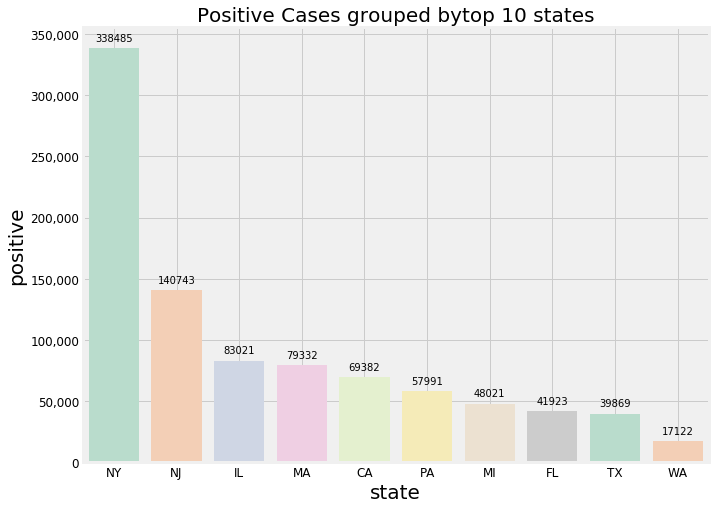

In [8]:
from matplotlib.ticker import StrMethodFormatter
f, ax = plt.subplots(figsize=(10, 8))
splot = sns.barplot(x=count_df.state, y=count_df.positive, 
            label="Positive counts by state",  ax=ax, 
           palette="Pastel2",
           )
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax.grid(axis='x')
ax.set_title("Positive Cases grouped bytop 10 states", loc='center', fontsize=20)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()

New York and New Jersey has over 450,000 positive cases in total as of 10th May.

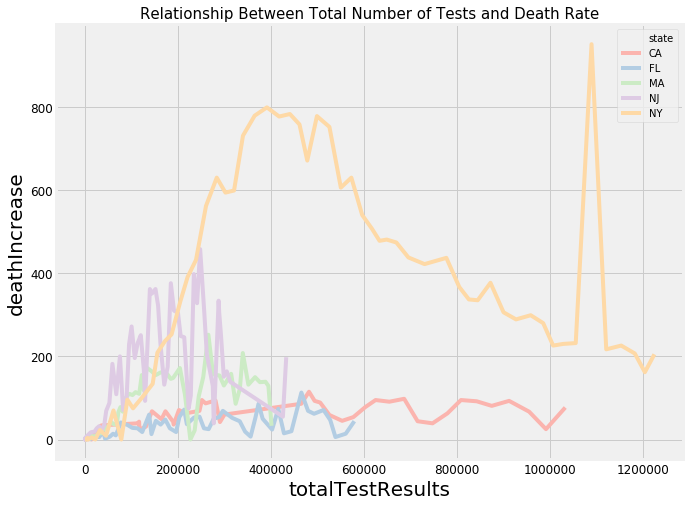

In [9]:
#Lineplot for Relationship Between Total Number of Tests and Death Rate
f, ax = plt.subplots(figsize=(10, 8))
df_lineplot = df.loc[df['state'].isin(['NY','CA', 'FL', 'NJ', 'MA'])]
ax = sns.lineplot(x="totalTestResults", 
                   y="deathIncrease", hue='state', data=df_lineplot, palette='Pastel1')
ax.set_title('Relationship Between Total Number of Tests and Death Rate', size=15)
ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.show()

We could see that as the number of tests increase, the death rate is falling down. Ofcourse, there will be significant number of positive cases as there are more tests taken, but it drastically reduces the death rate. This is because as more number of tests are taken, the victims know their status and can carry out preventive measures from having the virus spread. The -200 death increase at Philadelphia means that there are no death increase but rather increased recovery.

As the test increases, the recovery increases. This could mean that those who were tested positive are quarantined reducing the risks of spreading it further. With increase in tests, the number of cases will eventually increase, but the rate of death will comparatively be lesser. We could check which state has recovered the most and follow their way of lifestyle to flatten the curve. 

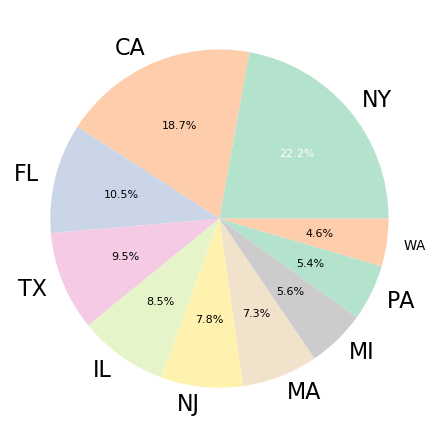

In [10]:
#Subsetting data
vis_df1 = vis_df.copy()
vis_df1.date = pd.to_datetime(vis_df1['date'], format='%Y%m%d')
vis_df1.date = vis_df1.date.max()
count_df = vis_df1.groupby(by=['date','state'])['total'].max().reset_index()
count_df.sort_values('total', ascending=False, inplace=True)
count_df = pd.DataFrame(count_df)
count_df.head()

#Pie chart
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"), dpi= 80)
patches, texts, autotexts = ax.pie(x=count_df.total, labels=count_df.state, 
       autopct='%1.1f%%',
      colors=sns.color_palette("Pastel2"))

plt.setp(texts, size=20)
plt.setp(autotexts, size='medium')
plt.setp(texts[-1], size='large')
autotexts[0].set_color('white')

plt.show()

Not to mislead you, this is a subset of the data, so the rates will differ. The statewise highest number of rates is still New York with 308,000 cases at the moment (May 1st). If you are wondering why CA is second biggest, well, this piechart is the sum of both positive and negative cases, not just positive cases.

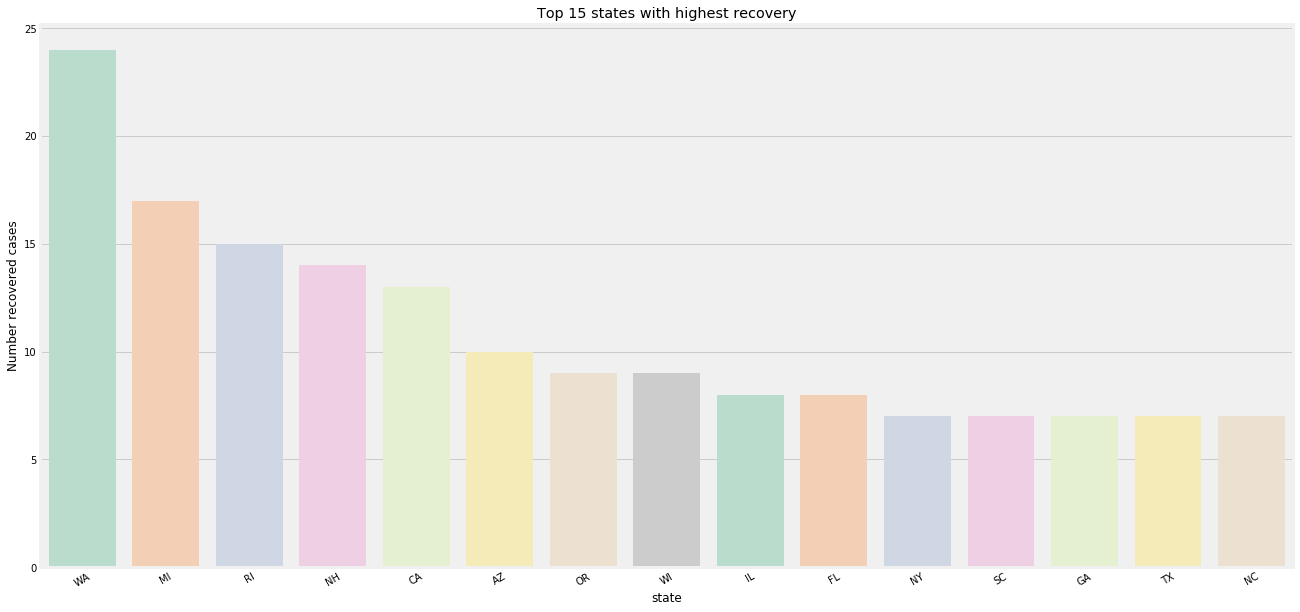

In [11]:
#barplot for statewise recovery
plt.figure(figsize=(20,10))

sns.barplot(x=df['state'].value_counts().nlargest(15).index, 
            y=df['recovered'].value_counts().nlargest(15), palette="Pastel2")

plt.xticks(rotation=30)
plt.title('Top 15 states with highest recovery')
plt.xlabel('state')
plt.ylabel('Number recovered cases')
plt.show()

We see a high recovery in WA. Today (27th April 2020), there are 508 patients hospitalized with COVID-19, and 145 of them are in intensive care in WA. according to KOMONEWS. This could be the reason the governor has announced gradual opening of economy.

In [12]:
# vis_df data is prone to misreported numbers or errors, we can smooth the reported positives by looking at 
# positive case growth every 2 days. credits: from the git hub repo. 
vis_df["positiveIncreaseLag"] = vis_df.groupby("state")["positiveIncrease"].shift(1)
vis_df["twoDayPositiveIncrease"] = vis_df["positiveIncrease"] + vis_df["positiveIncreaseLag"]
smoothed_vis_df = vis_df.loc[vis_df["date"] % 2 == 0]

# plot drop off
smoothed_vis_df["logPositiveNew"] = np.log(smoothed_vis_df["twoDayPositiveIncrease"])
smoothed_vis_df["logPositiveTotal"] = np.log(smoothed_vis_df["positive"])


# plot variables and settings
latest_update = str(smoothed_vis_df["date"].max())

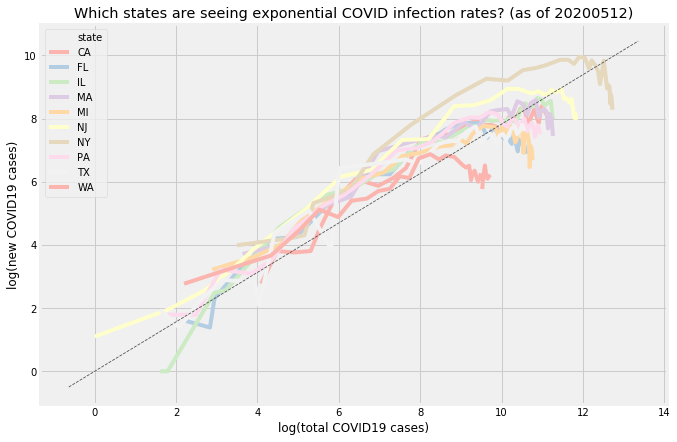

In [13]:
plt.figure(figsize=(10,7))
ax = sns.lineplot(
    x="logPositiveTotal",
    y="logPositiveNew",
    hue="state",
    data=smoothed_vis_df,
    palette = 'Pastel1'
)

ax.set(
    xlabel="log(total COVID19 cases)",
    ylabel="log(new COVID19 cases)",
    title=f"Which states are seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()

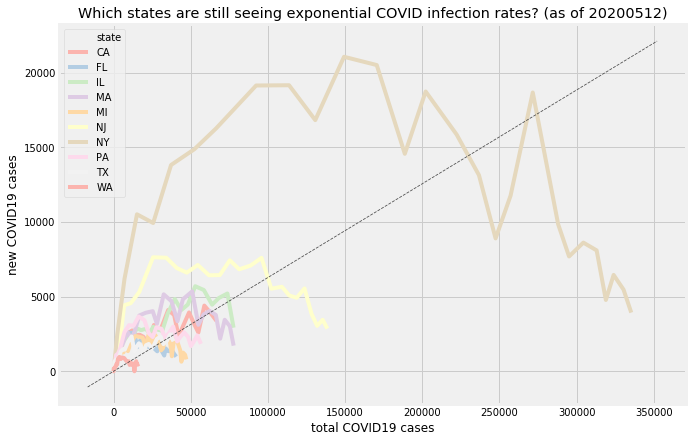

In [14]:
# linear-scale plot of growth rate v total (positives)
plt.figure(figsize=(10,7))
ax = sns.lineplot(
    x="positive",
    y="twoDayPositiveIncrease",
    hue="state",
    data=smoothed_vis_df,
    palette='Pastel1'
)

ax.set(
    xlabel="total COVID19 cases",
    ylabel="new COVID19 cases",
    title=f"Which states are still seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()


We can see that the new covid cases for New York and New Jersey have crossed the peak point and are starting to decline slowly. However, the plot might seem a lot volatile at the moment as it has just started to decline and will take atleast a week to form a steady downfall.

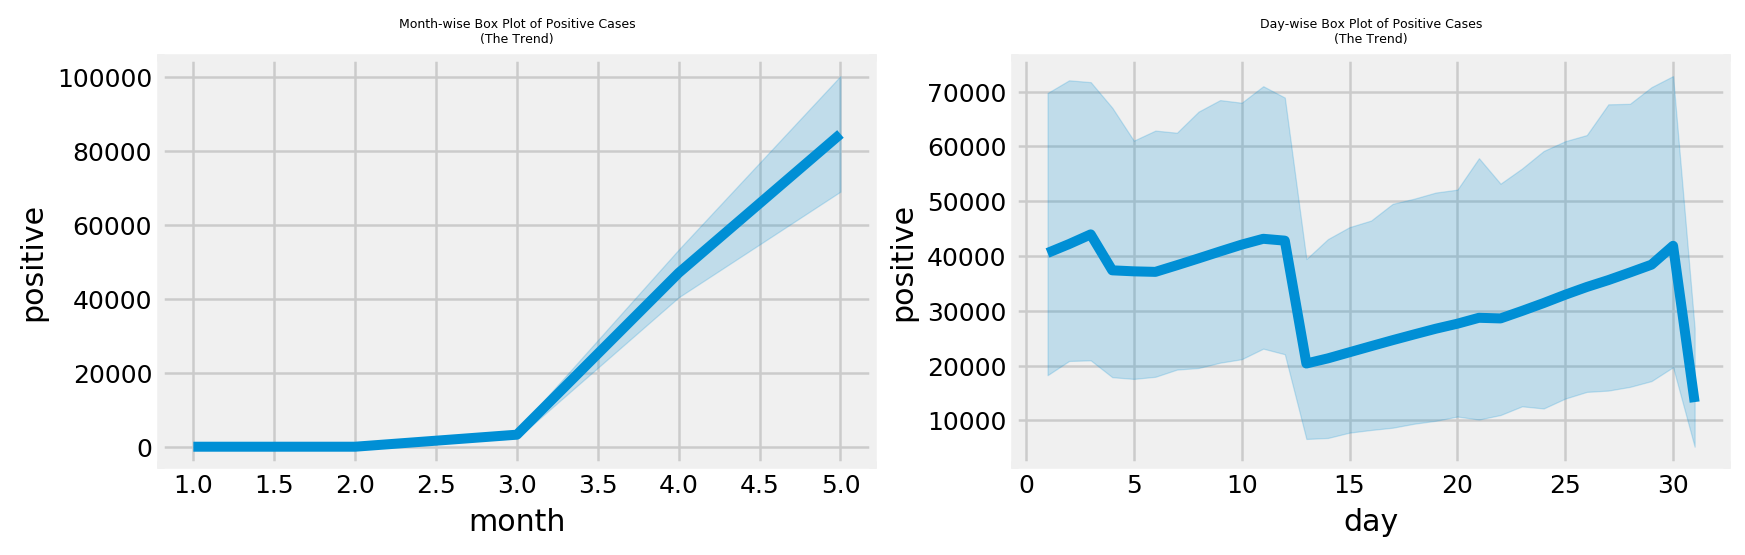

In [15]:
#drawing boxplot
fig, axes = plt.subplots(1, 2, figsize = (10,3), dpi = 180)
vis_df1= vis_df

vis_df1.date = pd.to_datetime(vis_df1['date'], format='%Y%m%d')
vis_df1['month'] = pd.DatetimeIndex(vis_df1['date']).month
vis_df1['day'] = pd.DatetimeIndex(vis_df1['date']).day

sns.lineplot(x = 'day', y = 'positive', data = vis_df1, ax = axes[1])
sns.lineplot(x = 'month', y = 'positive', data = vis_df1, ax = axes[0])

# Set Title
axes[0].set_title('Month-wise Box Plot of Positive Cases\n(The Trend)', fontsize = 5);
axes[1].set_title('Day-wise Box Plot of Positive Cases\n(The Trend)', fontsize = 5); 
plt.show()

We can clearly see the inflation in the boxplot from March to April and then May. However, they are claiming that the curve is flattening. Could be true as the number of tests increases, cases will proportionally increase too. What matters is the fatality rate and USA has done a great job in keeping it under most countries like Spain, UK etc. kudos to the health care workers and first responders!

For all you know, this pandemic could persist till next year or maybe even more. So, I have added an extra plot just the behavior of the plots can differ down the years.

Data Modeling

In [16]:
df.isnull().sum()

date                           0
state                          0
positive                      15
negative                     188
pending                     3096
hospitalizedCurrently       2262
hospitalizedCumulative      2293
inIcuCurrently              3021
inIcuCumulative             3502
onVentilatorCurrently       3176
onVentilatorCumulative      3719
recovered                   2418
dataQualityGrade            1105
lastUpdateEt                 373
hash                           0
dateChecked                    0
death                        726
hospitalized                2293
total                          0
totalTestResults               0
posNeg                         0
fips                           0
deathIncrease                 56
hospitalizedIncrease          56
negativeIncrease              56
positiveIncrease              56
totalTestResultsIncrease      56
dtype: int64

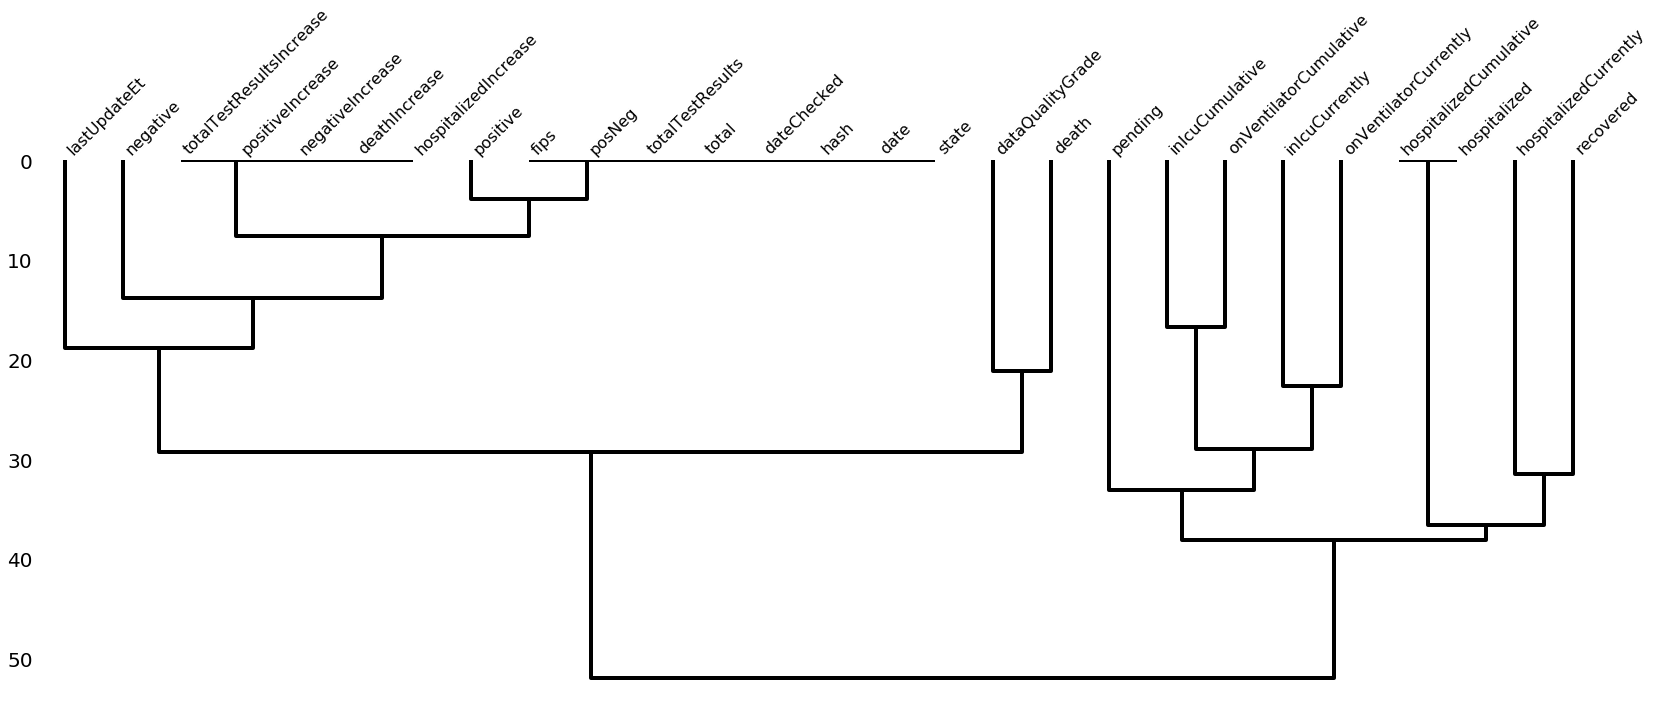

In [17]:
msno.dendrogram(df)

Lets drop columns that has a high number of null values

In [18]:
df.drop(columns=['pending','hospitalizedCurrently','hospitalizedCumulative', 'hospitalized', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative','recovered','hash','dateChecked', 'date'], inplace = True)
df.isnull().sum()

state                          0
positive                      15
negative                     188
dataQualityGrade            1105
lastUpdateEt                 373
death                        726
total                          0
totalTestResults               0
posNeg                         0
fips                           0
deathIncrease                 56
hospitalizedIncrease          56
negativeIncrease              56
positiveIncrease              56
totalTestResultsIncrease      56
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 15 columns):
state                       3825 non-null object
positive                    3810 non-null float64
negative                    3637 non-null float64
dataQualityGrade            2720 non-null object
lastUpdateEt                3452 non-null object
death                       3099 non-null float64
total                       3825 non-null int64
totalTestResults            3825 non-null int64
posNeg                      3825 non-null int64
fips                        3825 non-null int64
deathIncrease               3769 non-null float64
hospitalizedIncrease        3769 non-null float64
negativeIncrease            3769 non-null float64
positiveIncrease            3769 non-null float64
totalTestResultsIncrease    3769 non-null float64
dtypes: float64(8), int64(4), object(3)
memory usage: 448.4+ KB


In [20]:
LE = LabelEncoder()
df.state = LE.fit_transform(df.state)

In [21]:
df.describe()

state       positive       negative         death         total  \
count  3825.000000    3810.000000    3637.000000   3099.000000  3.825000e+03   
mean     27.824314    9272.862205   47501.196041    557.263311  5.466343e+04   
std      16.265642   29736.023997   93817.743987   1926.884472  1.158444e+05   
min       0.000000       0.000000       0.000000      0.000000  0.000000e+00   
25%      14.000000      76.000000    1303.000000      7.000000  8.680000e+02   
50%      28.000000    1080.500000   15196.000000     56.000000  1.476400e+04   
75%      42.000000    6110.750000   52695.000000    288.500000  5.702100e+04   
max      55.000000  338485.000000  963988.000000  21845.000000  1.225113e+06   

       totalTestResults        posNeg         fips  deathIncrease  \
count      3.825000e+03  3.825000e+03  3825.000000    3769.000000   
mean       5.440299e+04  5.440299e+04    32.299869      20.328204   
std        1.157642e+05  1.157642e+05    18.556830      66.890849   
min        0.000000e+00  0.000000e+00     1.000000    -201.000000   
25%        7.930000e+02  7.930000e+02    17.000000       0.000000   
50%        1.472900e+04  1.472900e+04    32.000000       2.000000   
75%        5.650800e+04  5.650800e+04    46.000000      12.000000   
max        1.225113e+06  1.225113e+06    78.000000     951.000000   

       hospitalizedIncrease  negativeIncrease  positiveIncrease  \
count           3769.000000       3769.000000       3769.000000   
mean              40.722473       2202.869196        360.995224   
std              247.916316       5231.725870        931.364424   
min             -181.000000      -5174.000000       -383.000000   
25%                0.000000         26.000000          7.000000   
50%                0.000000        610.000000         73.000000   
75%                8.000000       2408.000000        311.000000   
max             7758.000000     163092.000000      11571.000000   

       totalTestResultsIncrease  
count               3769.000000  
mean                2561.393473  
std                 5719.136219  
min                -9269.000000  
25%                   63.000000  
50%                  712.000000  
75%                 2772.000000  
max               165227.000000

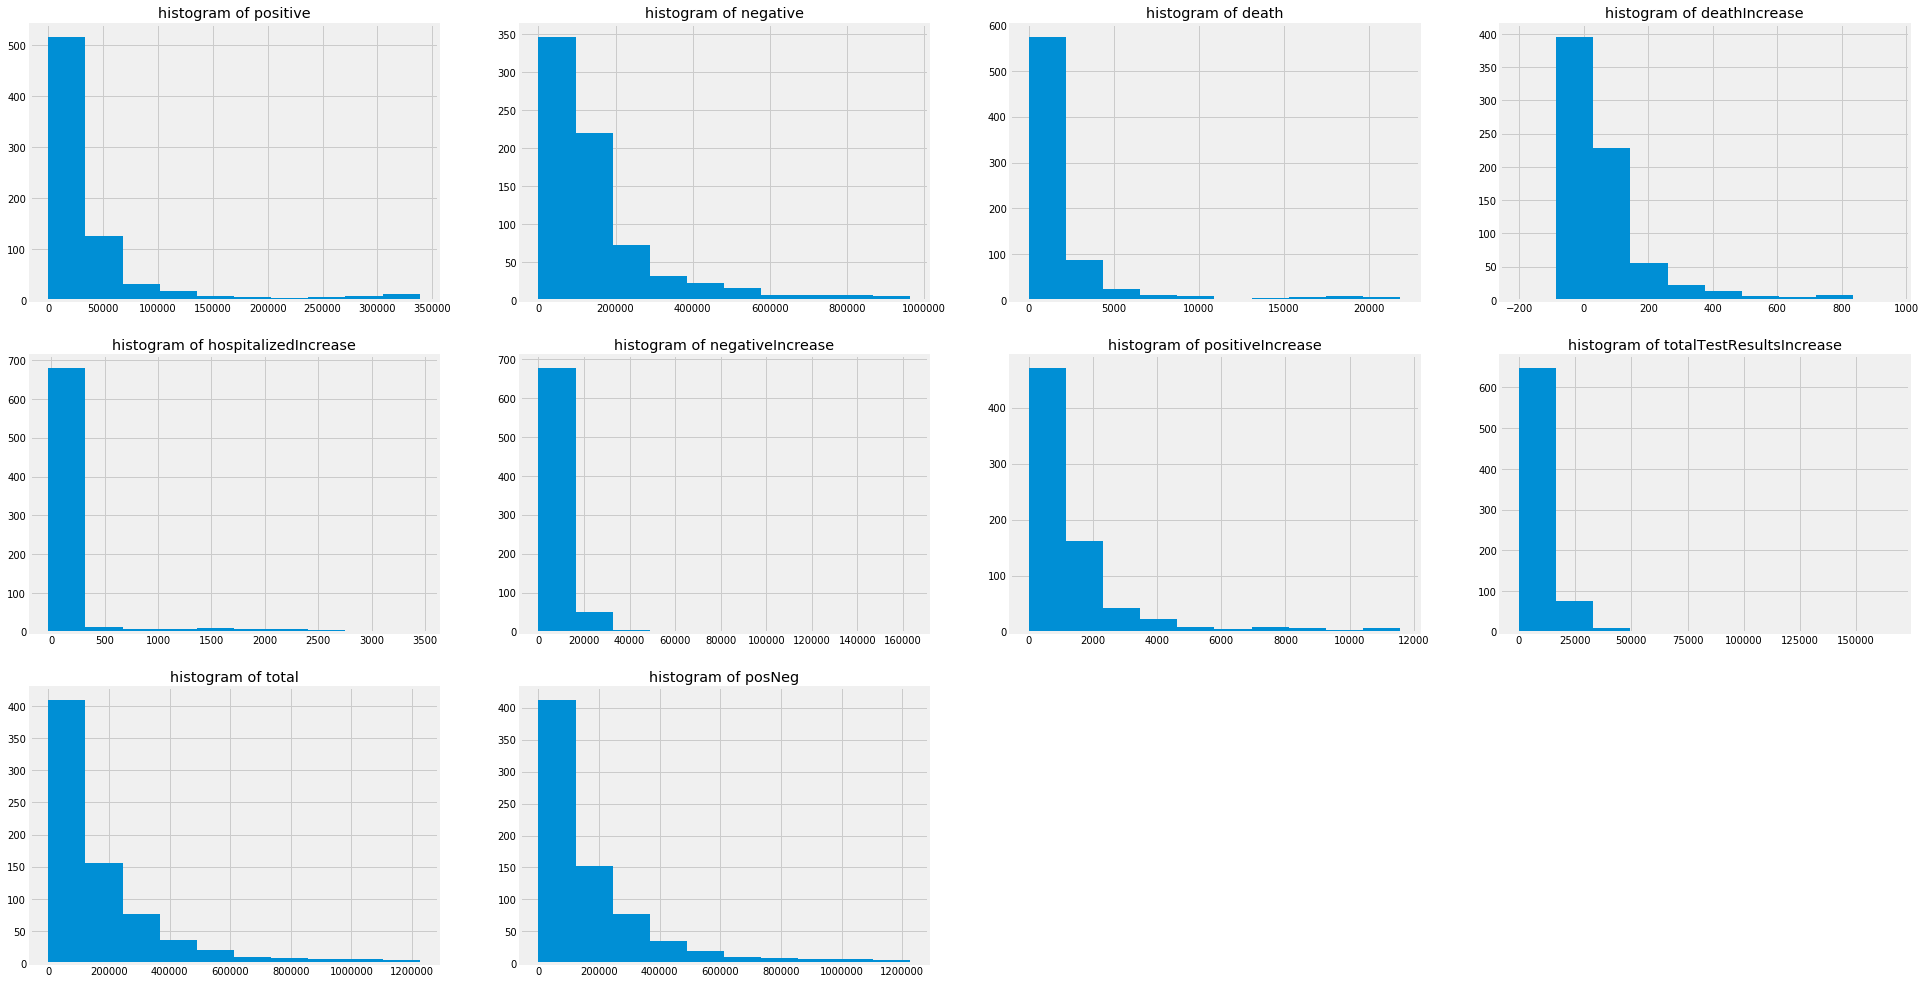

In [22]:
#Let's check the distribution:
List = ['positive', 'negative', 'death','deathIncrease', 'hospitalizedIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    vis_df[col].fillna(vis_df[col].mean(), inplace=True)
    plt.subplot(len(List),4,i+1)
    plt.hist((vis_df[col]))
    plt.title("histogram of {}".format(col))

plt.show()

The data is highly skewed, which is expected from this kind of dataset. 
Three ways to deal with skewed data: 
* log transformation
* Scipy's boxcox transformation
* Scipy's Yeo-Johnson transformation
* Mean square root
* winsorizing the data to remove outliers

**We will use log transformation and winsorization to get a better distribution.**

In [23]:
#Our data is highly skewed, the first step is to try np.log
#let's do that for observations greater than 0 as log would yield an infinite value for 0.
df.positive = np.log(df['positive'], where=df.positive>0)
df.negative = np.log(df['negative'], where=df.negative>0)
df.hospitalizedIncrease = np.log(df['hospitalizedIncrease'], where=df.hospitalizedIncrease>0)
df.death = np.log(df['death'], where=df.death>0)
df.negativeIncrease = np.log(df['negativeIncrease'], where=df.negativeIncrease>0)
df.positiveIncrease = np.log(df['positiveIncrease'], where=df.positiveIncrease>0)
df.totalTestResultsIncrease = np.log(df['totalTestResultsIncrease'], where=df.totalTestResultsIncrease>0)
df.total = np.log(df['total'], where=df.total>0)
df.totalTestResults = np.log(df['totalTestResults'], where=df.totalTestResults>0)
df.posNeg = np.log(df['posNeg'], where=df.posNeg>0)
df.deathIncrease = np.log(df['deathIncrease'], where=df.deathIncrease>0)

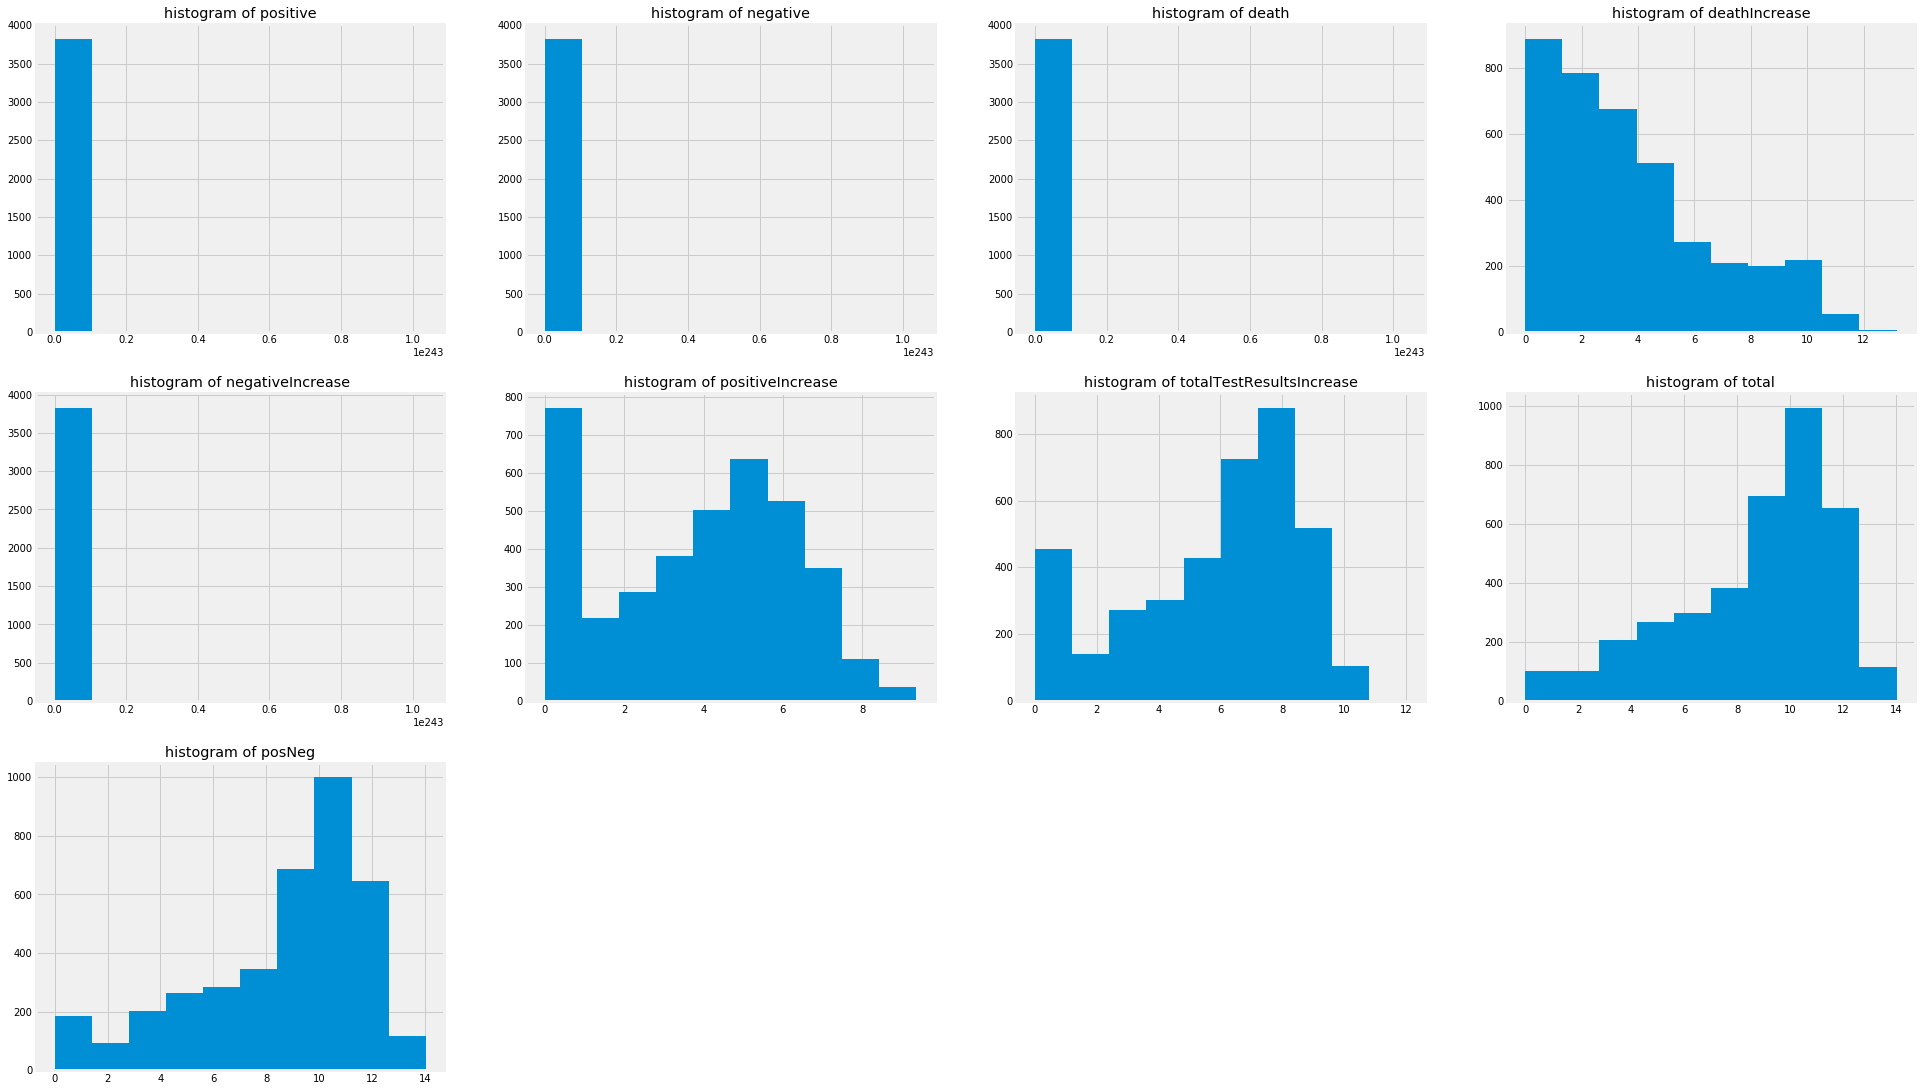

In [24]:
List = ['positive', 'negative', 'death','deathIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    plt.subplot(len(List),4,i+1)
    plt.hist(df[col])
    plt.title("histogram of {}".format(col))
plt.show()

In [25]:
List = ['positive', 'negative','hospitalizedIncrease','negativeIncrease','death', 'totalTestResultsIncrease', 'total','totalTestResults','posNeg','deathIncrease','positiveIncrease']
for i, col in enumerate (List):
#Normalizing the variable to get a better distribution
    df[col].fillna(df[col].mean(), inplace =True)
    df[col] = winsorize(df[col], (0.03, 0.01))

In [26]:
# List = ['positive', 'negative','hospitalizedIncrease','negativeIncrease','death', 'totalTestResultsIncrease', 'total','totalTestResults','posNeg','deathIncrease','positiveIncrease']
# for i, col in enumerate (List):
# # #Normalizing the variable to get a better distribution
#      df[col] = winsorize(df[col], (0, 0.01))

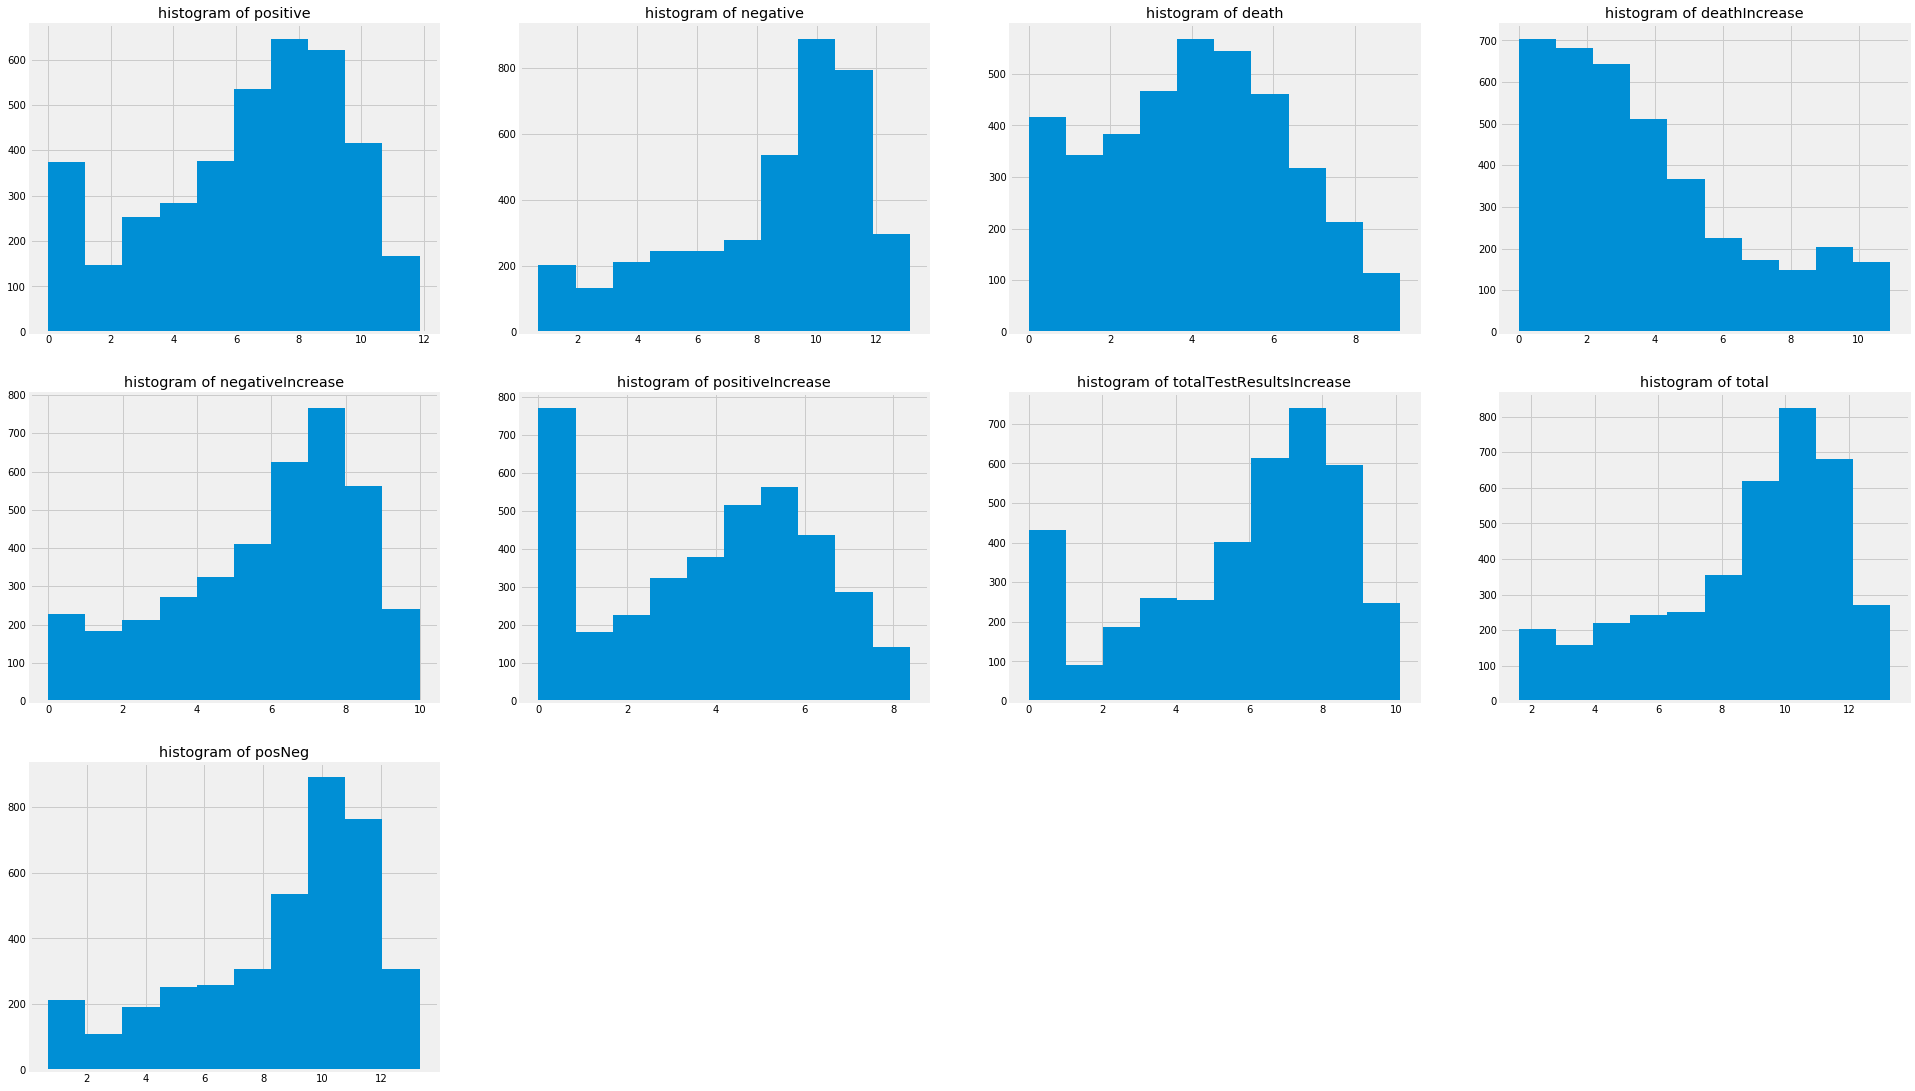

In [27]:
List = ['positive', 'negative', 'death','deathIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    plt.subplot(len(List),4,i+1)
    plt.hist(df[col])
    plt.title("histogram of {}".format(col))
plt.show()

The distribution looks better than how it was before normalizing it.

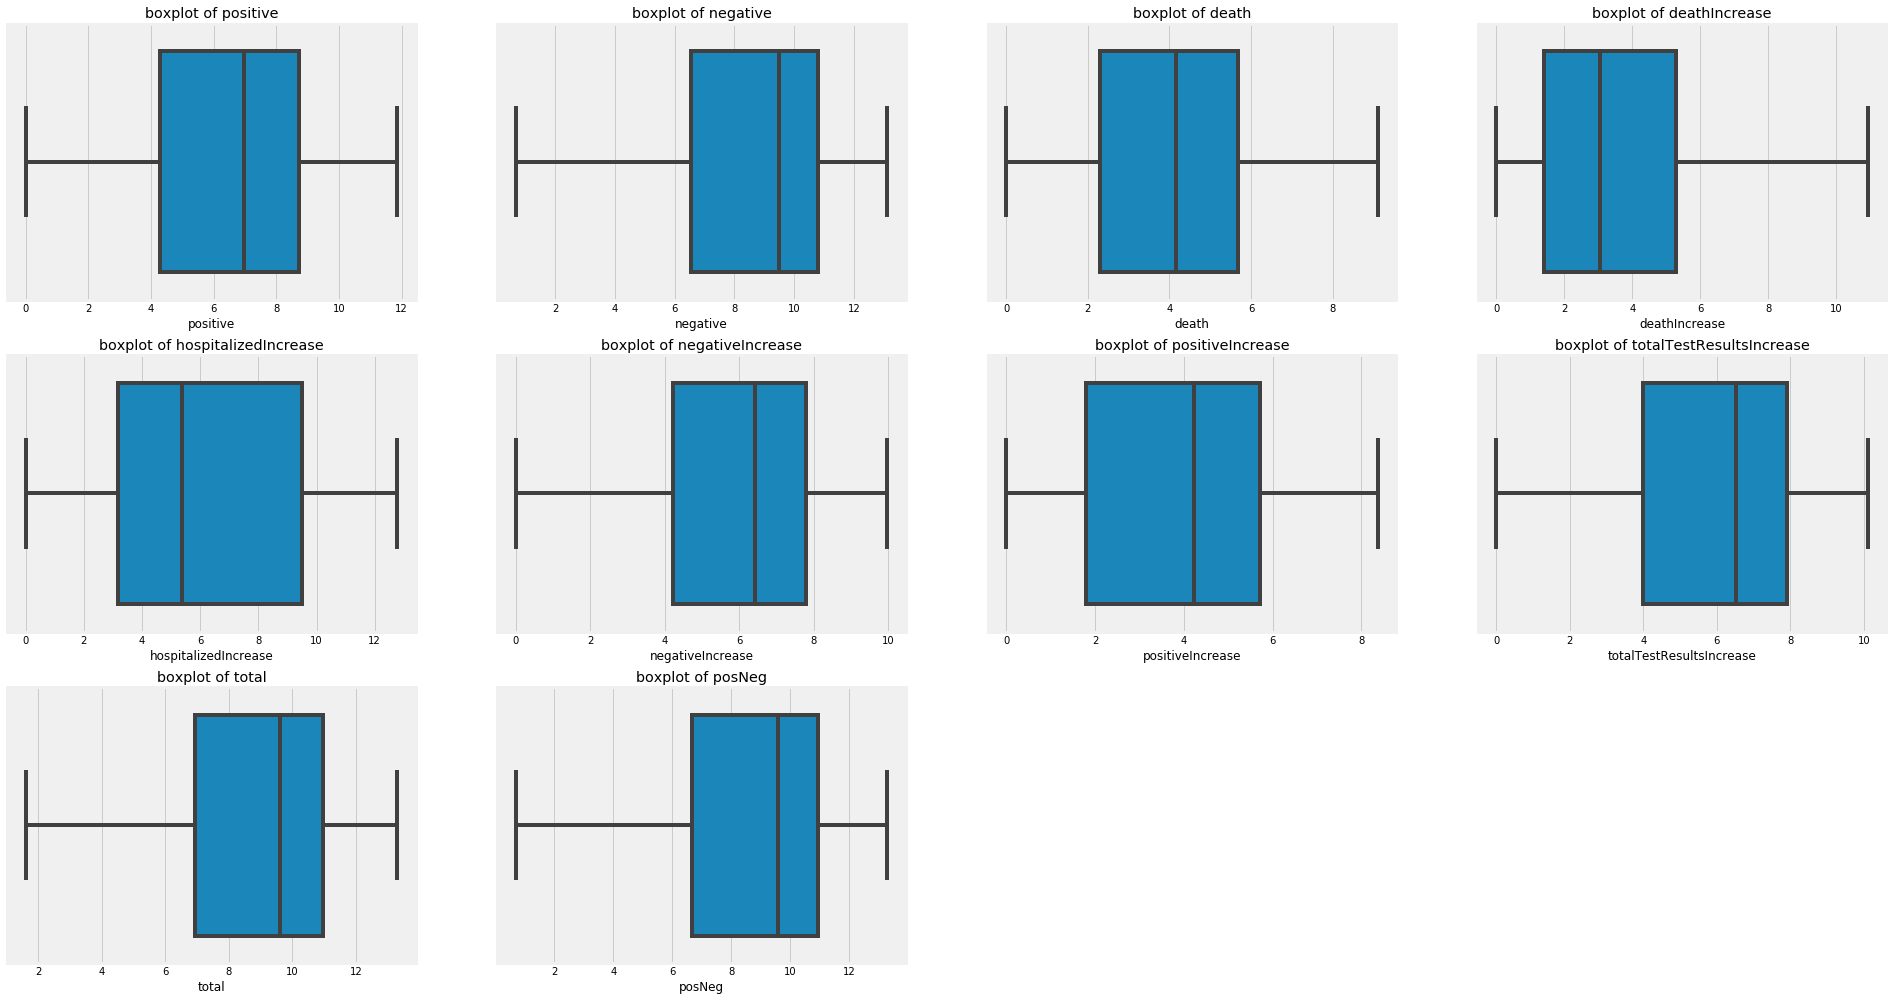

In [28]:
List = ['positive', 'negative', 'death','deathIncrease', 'hospitalizedIncrease','negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease','total','posNeg']
plt.figure(figsize=(30,60))
for i, col in enumerate (List):
    plt.subplot(len(List),4,i+1)
    sns.boxplot(df[col])
    plt.title("boxplot of {}".format(col))
    
plt.show()

No outliers, perfect for the regression model.

In [22]:
df.drop(columns=['dataQualityGrade','lastUpdateEt','hospitalizedIncrease','total','fips'], axis=1, inplace = True)

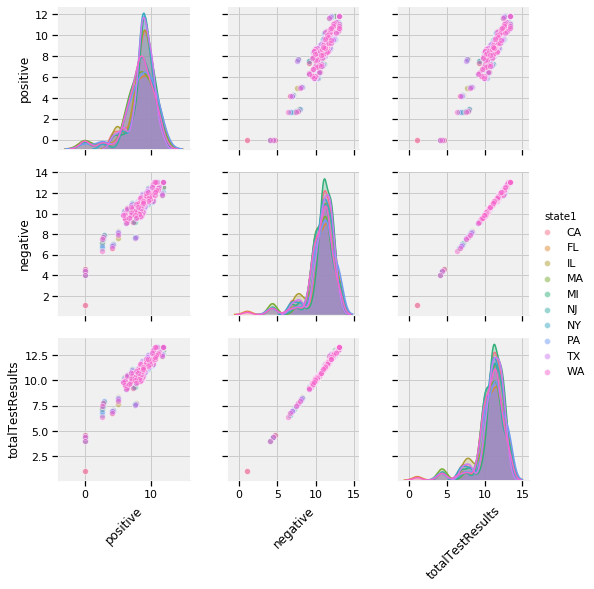

In [30]:
df['state1'] = vis_df['state']
with sns.plotting_context("notebook", font_scale=1):
    g = sns.pairplot(df, 
                 plot_kws={'alpha':0.5, },
                 vars=['positive', 
                       'negative', 'totalTestResults', 
                       ],
                 hue="state1", 
                markers= 'o',
                )
   
    for ax in g.axes.flat: 
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
plt.show()

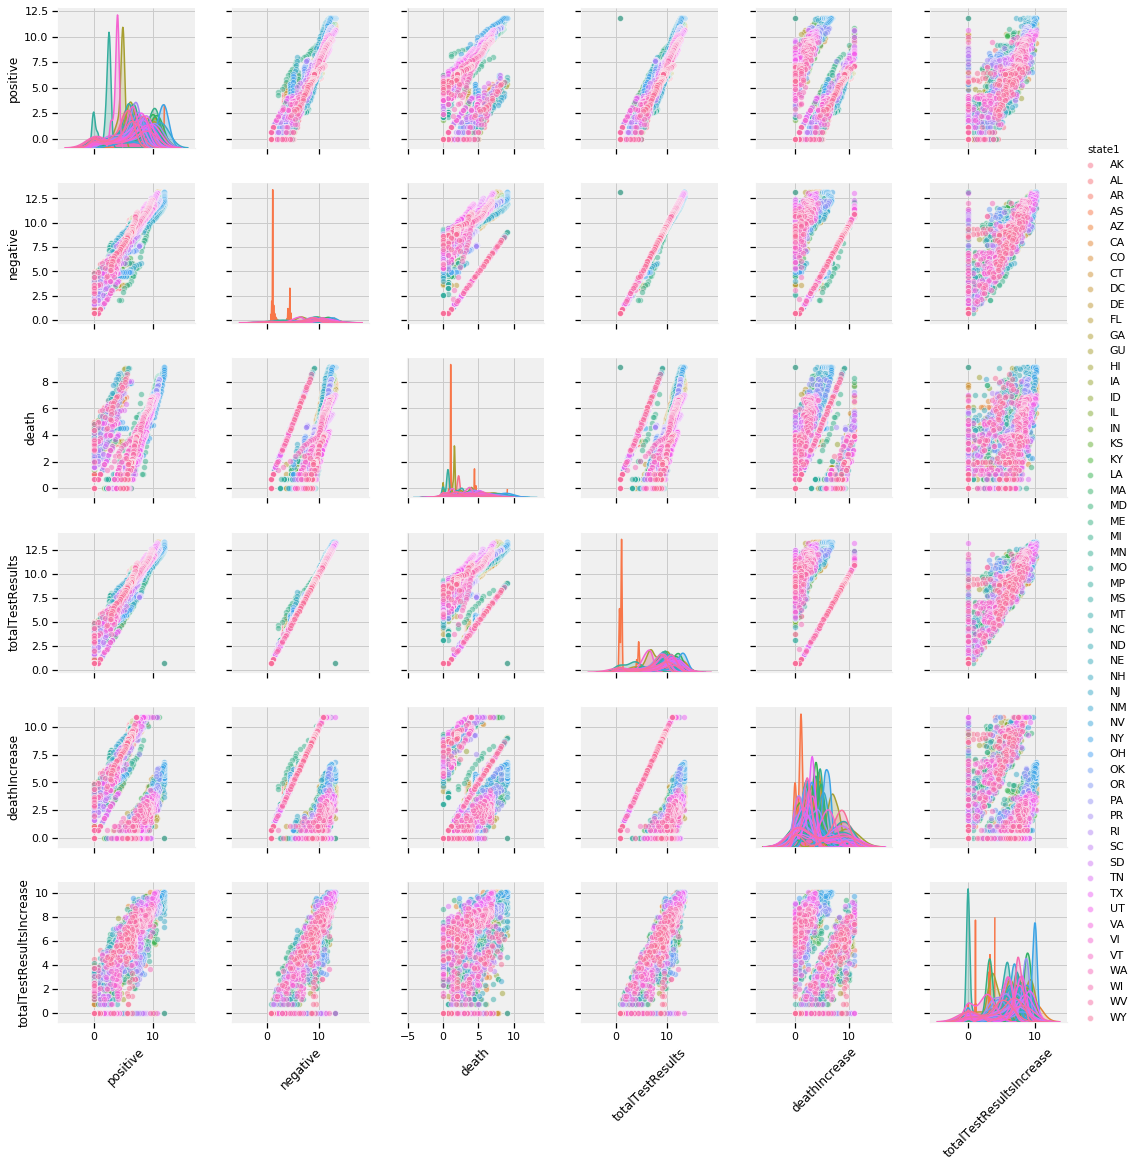

In [31]:
df['state1'] = LE.inverse_transform(df['state'])
with sns.plotting_context("notebook", font_scale=1):
    g = sns.pairplot(df, 
                 plot_kws={'alpha':0.5, },
                 vars=['positive', 
                       'negative', 'death', 'totalTestResults', 
                       'deathIncrease', 'totalTestResultsIncrease'],
                 hue="state1", 
                markers= 'o',
                )
   
    for ax in g.axes.flat: 
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
plt.show()

In [23]:
#Correlation Heatmap
corrs = df.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure

As expected, positive cases has high correlation with test results increase.

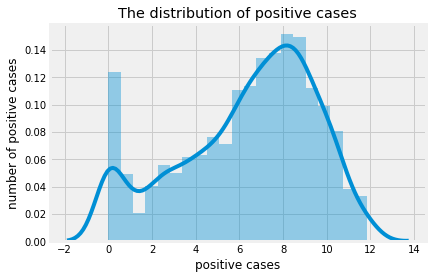

In [33]:
ax = sns.distplot(df.positive)
ax.set_title("The distribution of positive cases")
ax.set_xlabel("positive cases")
ax.set_ylabel("number of positive cases")
plt.show()

Linear Regression Model

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 11 columns):
state                       3825 non-null int64
positive                    3825 non-null float64
negative                    3825 non-null float64
death                       3825 non-null float64
totalTestResults            3825 non-null float64
posNeg                      3825 non-null float64
deathIncrease               3825 non-null float64
negativeIncrease            3825 non-null float64
positiveIncrease            3825 non-null float64
totalTestResultsIncrease    3825 non-null float64
state1                      3825 non-null object
dtypes: float64(9), int64(1), object(1)
memory usage: 328.8+ KB


In [35]:
df.isnull().sum()

state                       0
positive                    0
negative                    0
death                       0
totalTestResults            0
posNeg                      0
deathIncrease               0
negativeIncrease            0
positiveIncrease            0
totalTestResultsIncrease    0
state1                      0
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 11 columns):
state                       3825 non-null int64
positive                    3825 non-null float64
negative                    3825 non-null float64
death                       3825 non-null float64
totalTestResults            3825 non-null float64
posNeg                      3825 non-null float64
deathIncrease               3825 non-null float64
negativeIncrease            3825 non-null float64
positiveIncrease            3825 non-null float64
totalTestResultsIncrease    3825 non-null float64
state1                      3825 non-null object
dtypes: float64(9), int64(1), object(1)
memory usage: 328.8+ KB


In [37]:
X = df.drop(columns=['positive','state1'], axis=1)
Y = df.positive

In [38]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 450)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               positive   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     7859.
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        14:55:15   Log-Likelihood:                -3091.9
No. Observations:                3060   AIC:                             6202.
Df Residuals:                    3051   BIC:                             6256.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9691      0.044    -22.134      0.000      -1.055      -0.883
state                       -0.0015      0.001     -2.002      0.045      -0.003   -3.09e-05
negative                     0.4606      0.034     13.382      0.000       0.393       0.528
death                        0.0499      0.007      6.766      0.000       0.035       0.064
totalTestResults             0.1619      0.017      9.253      0.000       0.128       0.196
posNeg                       0.1619      0.017      9.253      0.000       0.128       0.196
deathIncrease               -0.0024      0.005     -0.519      0.603      -0.011       0.007
negativeIncrease            -0.0438      0.014     -3.061      0.002      -0.072      -0.016
positiveIncrease             0.5349      0.012     46.057      0.000       0.512       0.558
totalTestResultsIncrease    -0.2197      0.014    -15.924      0.000      -0.247      -0.193
==============================================================================
Omnibus:                      596.100   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7265.259
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                      10.465   Cond. No.                     4.97e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.62e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

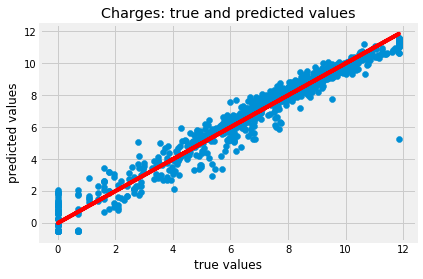

Mean absolute error of the prediction is: 0.5043606797905388
Mean squared error of the prediction is: 0.47443989153307575
Root mean squared error of the prediction is: 0.6887959723554398
Mean absolute percentage error of the prediction is: inf


In [39]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

**Linear Regression**

In [40]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.9537171918335836
-----Test set statistics-----
R-squared of the model in test set is: 0.9528838779872066
Mean absolute error of the prediction is: 0.5043606797905441
Mean squared error of the prediction is: 0.4744398915330754
Root mean squared error of the prediction is: 0.6887959723554395
Mean absolute percentage error of the prediction is: inf


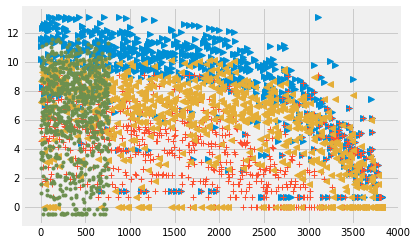

In [41]:
plt.plot(X_test['negative'],'>',X_test['death'],'+', X_test['totalTestResultsIncrease'], '<',
         lrm.predict(X_test),'.')
plt.show()

**Lasso Regression** 

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models

In [42]:
## 10** (p-values from -10 to 40)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.9501806045233768
-----Test set statistics-----
R-squared of the model in test set is: 0.9495240537409843
Mean absolute error of the prediction is: 0.5107126762477951
Mean squared error of the prediction is: 0.5082719342150923
Root mean squared error of the prediction is: 0.7129319281776433
Mean absolute percentage error of the prediction is: inf


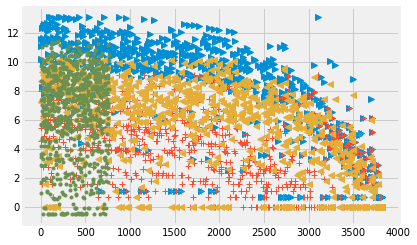

In [43]:
plt.plot(X_test['negative'],'>',X_test['death'],'+', X_test['totalTestResultsIncrease'], '<',
         lasso_cv.predict(X_test),'.')
plt.show()

**Ridge Regression**

In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

In [44]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1000.0
R-squared of the model in training set is: 0.9510719892697533
-----Test set statistics-----
R-squared of the model in test set is: 0.9492720157487092
Mean absolute error of the prediction is: 0.49543075467822867
Mean squared error of the prediction is: 0.5108098527153605
Root mean squared error of the prediction is: 0.7147096282514742
Mean absolute percentage error of the prediction is: inf


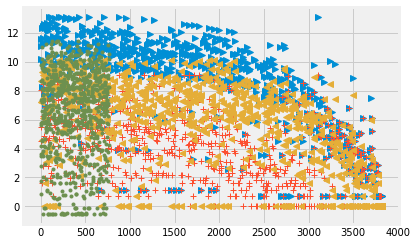

In [45]:
plt.plot(X_test['negative'],'>',X_test['death'],'+',X_test['totalTestResultsIncrease'], '<',
         ridge_cv.predict(X_test),'.')
plt.show()

**ElasticNet Regression**

ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is that, it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

In [46]:
## 10** (p-values from -10 to 40)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.9521136080749847
-----Test set statistics-----
R-squared of the model in test set is: 0.95092037965476
Mean absolute error of the prediction is: 0.5021525638448174
Mean squared error of the prediction is: 0.49421150889195836
Root mean squared error of the prediction is: 0.7030017844159134
Mean absolute percentage error of the prediction is: inf


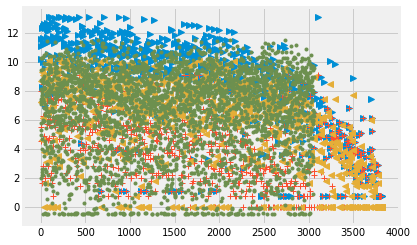

In [47]:
plt.plot(X_test['negative'],'>',X_test['death'],'+',X_test['totalTestResultsIncrease'], '<',
         elasticnet_cv.predict(X_train),'.')
plt.show()

In [48]:
#predictions!
df_pred = pd.DataFrame(y_preds_test, columns=['Predictions of Positive Cases'])
df_pred.head()

Predictions of Positive Cases
0                       3.399617
1                       9.746597
2                       7.349890
3                       3.714009
4                       2.804066

**Evaluation**

The model was analysed with different regression models. We were able to find the highest R values in Linear regression and Ridge regression. The values did not vary much from the other models. We will now try to include other factors that could possibly affect our model.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=40)
clf = LinearRegression()
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.95075595 0.94700877 0.95672897 0.95478199 0.93246272]
Mean cross validatiion score: 0.948


### Conclusion for part 1 of the project:
* The data was visualized for the top 10 countries that are affected, putting them in priority.
* Washington State's recovery level is comparatively higher to other states.
* New York city is the highest affected, however, the curve is starting to flatten from the peak.
* I could have hypertuned it by adding features, but it would not make sense for a covid-19 dataset.
* All the models are predicting a good score of about 95%.
* The accuracies were cross validated using k-fold method.
* MAE, MSE, RMSE and MAPE are considerably low which is good for the model.

In [50]:
!nbmerge Final_1.ipynb Final_2.ipynb > Final.ipynb

Traceback (most recent call last):
  File "/Users/sajithgowthaman/opt/anaconda3/bin/nbmerge", line 10, in <module>
    sys.exit(main())
  File "/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/nbmerge/__init__.py", line 189, in main
    plan = parse_plan(args)
  File "/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/nbmerge/__init__.py", line 173, in parse_plan
    raise IOError("Notebook `{}` does not exist".format(file_path))
OSError: Notebook `Final_1.ipynb` does not exist


### Final Capstone Project - Part 2

* Predicting COVID-19 Using Deep Learning's CNN

### Introduction:

As mentioned above, I will use an open reasearch database from github that provides chest x-ray images of covid-19 patients and combine another dataset that contains chest x-rays of normal patients.

In [1]:
import pandas as pd
import numpy as np# forlinear algebra
from numpy import array 
import matplotlib.pyplot as plt #for plotting things
import seaborn as sns
import os
from PIL import Image
from pathlib import Path
from skimage.io import imread
import cv2
from sklearn.metrics import confusion_matrix
print(os.listdir("../chest_xray/chest_xray2/train/"))

# Keras Libraries
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

['covid19', '.DS_Store', 'normal']


Using TensorFlow backend.
/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sajithg

In [2]:
data_dir = Path('../chest_xray/chest_xray2')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [3]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'normal/'
covid19_cases_dir = train_dir / 'covid19/'

types = ('*.jpg', '*.jpeg', '*.png') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in covid19_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

image  label
0  ../chest_xray/chest_xray2/train/normal/NORMAL2...      0
1  ../chest_xray/chest_xray2/train/covid19/augmen...      1
2  ../chest_xray/chest_xray2/train/normal/IM-0122...      0
3  ../chest_xray/chest_xray2/train/covid19/augmen...      1
4  ../chest_xray/chest_xray2/train/covid19/augmen...      1

1    1746
0    1215
Name: label, dtype: int64


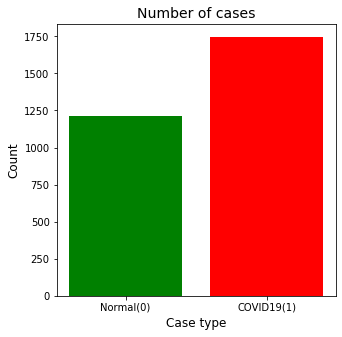

In [4]:
%matplotlib inline
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,5))
plt.bar(cases_count.index, cases_count.values, color='rg')
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'COVID19(1)'])
plt.show()

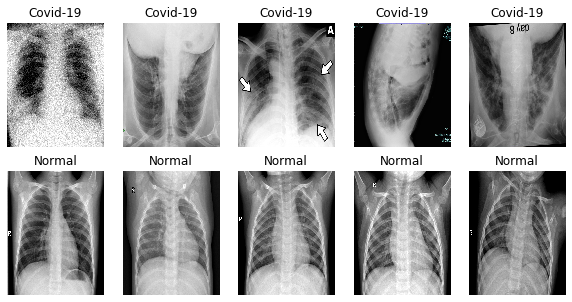

In [5]:
# Get few samples for both the classes
covid19_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = covid19_samples + normal_samples
del covid19_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Covid-19")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [6]:
#Validation dats
# Get the path to the normal and covi-19 sub-directories
normal_cases_dir = val_dir / 'normal/'
covid19_cases_dir = val_dir / 'covid19/'

types = ('*.jpg', '*.jpeg', '*.png') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 64x64 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1: #for gray scale hxwxrgb, we are converting it to a RGB version
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (426, 64, 64, 3)
Total number of labels: (426, 2)


In [7]:
import imgaug.augmenters as iaa
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [8]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (64,64))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [9]:
visible = Input(shape=(64,64,3))
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(visible)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
bat1 = BatchNormalization()(conv2)
zero1 = ZeroPadding2D(padding=(1, 1))(bat1)

conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(zero1)
conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(conv3)
bat2 = BatchNormalization()(conv4)

conv5 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(bat2)
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv5)
bat3 = BatchNormalization()(conv6)
pool1 = MaxPooling2D(pool_size=(2, 2))(bat3)
zero2 = ZeroPadding2D(padding=(1, 1))(pool1)

conv7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(zero2)
conv8 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv7)
bat4 = BatchNormalization()(conv8)

conv9 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(bat4)
conv10 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv9)
bat5 = BatchNormalization()(conv10)

conv11 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(bat5)
conv12 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv11)
bat6 = BatchNormalization()(conv12)
pool2 = MaxPooling2D(pool_size=(2, 2))(bat6)

conv13 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(pool2)
conv14 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv13)
bat7 = BatchNormalization()(conv14)

conv15 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(bat7)
conv16 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv15)
bat8 = BatchNormalization()(conv16)

flat = Flatten()(bat8)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.5)(hidden1)

hidden2 = Dense(32, activation='relu')(hidden1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(2, activation='softmax')(drop2)
model = Model(inputs=visible, outputs=output)

In [10]:
model.compile(optimizer= 'adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
Callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(patience=2)]    

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 32)        9248

In [11]:
import h5py
# Open the VGG16 weight file
f = h5py.File('../chest_xray/chest_xray2/vgg/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 32)        9248

In [12]:
batch_size = 32
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 92 and 426


In [13]:
#Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks= Callbacks, verbose=1)

Epoch 1/20
92/92 [==============================] - 107s 1s/step - loss: 11.1632 - accuracy: 0.8203 - val_loss: 9.0591 - val_accuracy: 0.5070
Epoch 2/20
92/92 [==============================] - 104s 1s/step - loss: 6.7122 - accuracy: 0.8971 - val_loss: 5.8515 - val_accuracy: 0.5070
Epoch 3/20
92/92 [==============================] - 108s 1s/step - loss: 4.2223 - accuracy: 0.9107 - val_loss: 4.4000 - val_accuracy: 0.5070
Epoch 4/20
92/92 [==============================] - 106s 1s/step - loss: 2.7369 - accuracy: 0.9202 - val_loss: 3.8388 - val_accuracy: 0.5070
Epoch 5/20
92/92 [==============================] - 105s 1s/step - loss: 1.8522 - accuracy: 0.9144 - val_loss: 2.9783 - val_accuracy: 0.5070
Epoch 6/20
92/92 [==============================] - 104s 1s/step - loss: 1.2830 - accuracy: 0.9185 - val_loss: 1.9133 - val_accuracy: 0.5657
Epoch 7/20
92/92 [==============================] - 103s 1s/step - loss: 0.9484 - accuracy: 0.9154 - val_loss: 1.5155 - val_accuracy: 0.5446
Epoch 8/20
9

**Few ways in which we improved the test accuracy from 50% to 98%:**
* Using weighted regularization to keep the weights as low as possible for better generalization, we used kernel_regularizer=regularizers.l2(0.05.
* Increasing training set, we did that by rotating, flipping and adding noise.
* Randomly substituting some pixels with black and white - this cannot be applied here as we only use black and white pixels for chest xrays
* Experimented with various neruons and input.
* Pre-trained the model using VGG-16 from h5py package which forces the model to extract the useful aspects of the image.

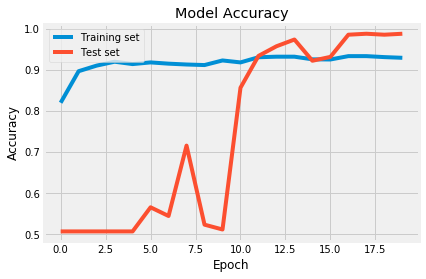

In [14]:
import matplotlib
matplotlib.style.use("fivethirtyeight")
# Accuracy
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

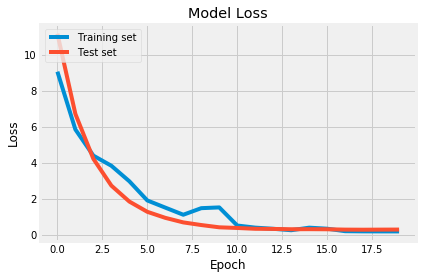

In [15]:
# Loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [16]:
# import numpy as np
# import cv2
# from skimage import io 
# from skimage.transform import rotate, AffineTransform, warp
# import random
# from skimage import img_as_ubyte
# import os
# from skimage.util import random_noise
# #Lets define functions for each operation
# def anticlockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, angle)

# def clockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, -angle)

# def h_flip(image):
#     return  np.fliplr(image)

# def v_flip(image):
#     return np.flipud(image)

# def add_noise(image):
#     return random_noise(image)

In [17]:
# transformations = {'rotate anticlockwise': anticlockwise_rotation,
#                       'rotate clockwise': clockwise_rotation,
#                       'horizontal flip': h_flip, 
#                       'vertical flip': v_flip,
#                    'adding noise': add_noise,
#                  }                #use dictionary to store names of functions 

# images_path='../chest_xray/chest_xray2/images' #path to original images
# augmented_path="../chest_xray/chest_xray2/train covid19" # path to store aumented images
# images=[] # to store paths of images from folder

# for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
#     images.append(os.path.join(images_path,im))

# images_to_generate=2000  #you can change this value according to your requirement
# i=1                        # variable to iterate till images_to_generate

# while i<=images_to_generate:    
#     image=random.choice(images)
#     original_image = io.imread(image,plugin='matplotlib')
#     transformed_image=None
# #     print(i)
#     n = 0       #variable to iterate till number of transformation to apply
#     transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
#     while n <= transformation_count:
#         key = random.choice(list(transformations)) #randomly choosing method to call
#         transformed_image = transformations[key](original_image)
#         n = n + 1
        
#     new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
#     transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
#     transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
#     cv2.imwrite(new_image_path, transformed_image) # save transformed image to path
#     i =i+1

In [18]:
#Test data
# Get the path to the normal and covi-19 sub-directories
normal_cases_dir = test_dir / 'normal/'
covid19_cases_dir = test_dir / 'covid19/'

types = ('*.jpg', '*.jpeg', '*.png') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (284, 64, 64, 3)
Total number of labels: (284, 2)


In [19]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

284/284 [==============================] - 2s 5ms/step
Loss on test set:  0.4029023284223718
Accuracy on test set:  0.8943662047386169


In [20]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(284,)
(284,)


In [21]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.81


<Figure size 432x288 with 0 Axes>

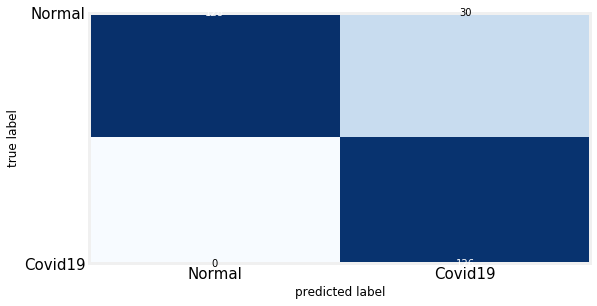

In [22]:
from mlxtend.plotting import plot_confusion_matrix
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(8,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Covid19'], fontsize=15)
plt.yticks(range(2), ['Normal', 'Covid19'], fontsize=15)
plt.show()

**Its better to have less false negative, because youre not diagnosing someone with covid-19 as normal.**

Prediction for test data containing covid-images:

In [23]:
#Test data
# Get the path to the normal and covi-19 sub-directories
covid19_cases_dir = test_dir / 'covid19/'

types = ('*.jpg', '*.jpeg', '*.png') # the tuple of file types

covid19_cases =[]
for files in types:
    covid19_cases.extend(covid19_cases_dir.glob(files))

test_data1 = []
test_labels = []
                      
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data1.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data1)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (126, 64, 64, 3)
Total number of labels: (126, 2)


In [51]:
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)
for i in preds:
    if preds[i] == [1]:
        print('COVID-19 Positive')
    elif preds[i] == [0]:
        print('COVID-19 Negative')

COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 Positive
COVID-19 P

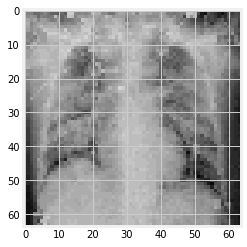

(1, 64, 64, 3)


In [28]:
from keras.preprocessing import image
img_path = '../chest_xray/chest_xray2/test/covid19/radiol.2020200274.fig3d.png'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

The model has predicted that the above xray image contains covid-19, which is true. 

Conclusion

* The Convolutional Neural Network was built using 16 convolutional layers, 2 hidden layer.
* The activation for the last layer used was 'softmax', with the remaining layers using 'relu'.
* Each convolutional layer was associated with batch normalization to improve the performance through recentering and rescaling.
* Padding was introduced to the layers to determine the amount of pixels to be added and with kernal regularizer, which is basically used in place of weight regularizer to work on the weights used in each layer.
* The model was optimized using 'adam' in order to find the individual learning rate of each parameter. The model was fitted with a pre-trained model - VGG16 for better training accuracy.
* The cross entropy was calculated to find performance, it increases as the predicted value is far away from true labels.
* The train and test accuracy were: 93% and 97% respectively
* The loss associated with the model: 27% loss was encountered.

#### Over all conclusion

* This project was used to predict the novel corona virus's positive cases and the presence of the virus in the chest image in minutes, which usually takes about hours to be determined using clinical test analysis.
* The model can be used to predict and help the doctor take measures in advance before the clinical test results arrive. The clinical analysis must be carried out for a confirmed 100% results as this involves life.
* The regressiong model accuracy was cross validated using K-fold evaluation for measuring 5 accuracies to achieve 90% + accuracy.
* Visualizations using matplotlib, seaborn was showcased to get a better understanding of the current standing of the virus.
* The data could have been made better if we had more variables such as age, sex, and their previous health conditions. This would have improved the project in many ways.
* The images for the covid-19 chest xrays were augmented for training purposes. The validation and test were carried out with real world chest-xray images of covid-19 victims.
* The model is learning through each epoch, and the accuracy of the training model is consistently increasing which shows a solid training model.
* Confusion matrix was plotted. The model is doing great with good ration of tp,tn>fp,fn.